In [1]:
using CUDA, Flux, JLD2

In [2]:
Threads.nthreads()

16

In [3]:
dev = gpu
β = 1.0

1.0

In [4]:
include("utils/train.jl")

In [111]:
# '''
# Eᵢ=a0 b0/λ - λ/2(u²-w²)
# u(t+1) = u(t) exp(-η ∇Eᵢ)/∑u(t) exp(-η ∇Eⱼ)
# ∇Eᵢ=-λᵢ uᵢ
# rᵢ⁺(t) = exp(η λᵢ uᵢ(t))
# rᵢ⁻(t) = exp(-η λᵢ uᵢ(t))
# qᵢ⁺(t) = exp(-η λᵢ wᵢ(t))
# qᵢ⁻(t) = exp(+η λᵢ wᵢ(t))

# 1. Initialize \vec{u} = \vec{0}, \vec{w} = \vec{0} and normalization values U1 and U2
# 2a. uᵢ⁺(t+1) = U1 ⋅ uᵢ⁺(t) rᵢ⁺(t)/∑ⱼuⱼ⁺(t) rⱼ⁺(t) + uⱼ⁻(t) rⱼ⁻(t)
# 2b. uᵢ⁻(t+1) = U1 ⋅ uᵢ⁻(t) rᵢ⁻(t)/∑ⱼuⱼ⁺(t) rⱼ⁺(t) + uⱼ⁻(t) rⱼ⁻(t)
# 2c. wᵢ⁺(t+1) = U2 ⋅ wᵢ⁺(t) qᵢ⁺(t)/∑ⱼwⱼ⁺(t) qⱼ⁺(t) + wⱼ⁻(t) qⱼ⁻(t)
# 2d. wᵢ⁻(t+1) = U2 ⋅ wᵢ⁻(t) qᵢ⁻(t)/∑ⱼwⱼ⁺(t) qⱼ⁺(t) + wⱼ⁻(t) qⱼ⁻(t)
# 3a. uᵢ(t+1) = uᵢ⁺(t+1) - uᵢ⁻(t+1)
# 3b. wᵢ(t+1) = wᵢ⁺(t+1) - wᵢ⁻(t+1)
# '''

In [6]:
function uwToxy(F, u, w) 
    λ = cpu(F.S)
    a0 = cpu(F.U' * J.a)[1:size(λ,1)]
    b0 = cpu(F.Vt * J.b)

    s = size(u,1)
    Rot = Tridiagonal([ isodd(i) ? 1 : 0 for i in 1:2*s-1] , [1 for i in 1:2*s] , [ isodd(i) ? -1 : 0 for i in 1:2*s-1])
    uw = Array(reshape(hcat(u, w)',:))
    xysp = Array(reshape(hcat(-b0 ./ λ, -a0 ./ λ)',:))
    xy = xysp + 1/√2 * Rot * uw
    x, y = reshape(xy', 2,:)'[:,1], reshape(xy', 2,:)'[:,2]
    return x, y
end

uwToxy (generic function with 1 method)

In [207]:
# modelName = "CD-500-T1000-5-BW-replica2-L"
modelName = "PCD-500-replica2"
rbm, J, m, hparams, opt = loadModel(modelName, gpu);
# rbm, J, m, hparams, rbmZ = initModel(nv=28*28, nh=500, batch_size=500, lr=1.5, t=10, gpu_usage = true, optType="Adam")
opt = initOptW(hparams, J);
x_i, y_i = loadData(; hparams, dsName="MNIST01", numbers=collect(0:9), testset=true);
TS = Test(x_i,y_i)
dict = loadDict(modelName);

[ Info: /home/javier/Projects/RBM/Results/models/PCD-500-replica2
[ Info: Loadding model J_100.
[ Info: 10000


In [208]:
J.w = gpu(J.w)
J.b = gpu(J.b)
J.a = gpu(J.a)
F = LinearAlgebra.svd(J.w, full=true);

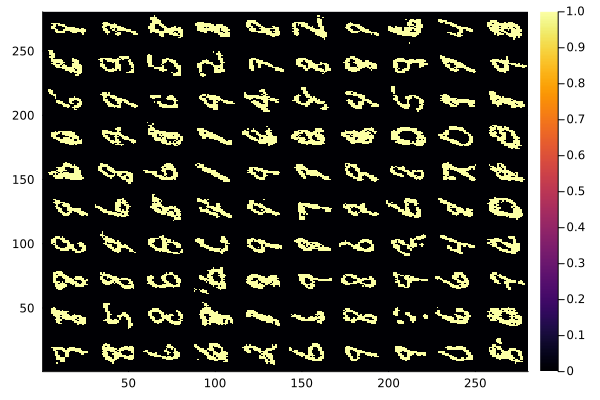

In [209]:
rbm.h = Array{Float32}(sign.(rand(hparams.nh, hparams.batch_size) |> dev .< σ.(β .* (J.w' * dev(rand(hparams.nv,hparams.batch_size)) .+ J.b)))) |> dev 
for i in 1:500
    # display(plotLandscapes(rbm, J, lnum ; τ=0, TS, dev, hparams))
    rbm.v = Array{Float32}(sign.(rand(hparams.nv, hparams.batch_size) |> dev .< σ.(β .* (J.w * rbm.h .+ J.a)))) |> dev  
    rbm.h = Array{Float32}(sign.(rand(hparams.nh, hparams.batch_size) |> dev .< σ.(β .* (J.w' * rbm.v .+ J.b)))) |> dev 
end
lnum=10
heatmap(cat([cat([reshape(cpu(rbm.v)[:,i+j*lnum],28,28) for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1))

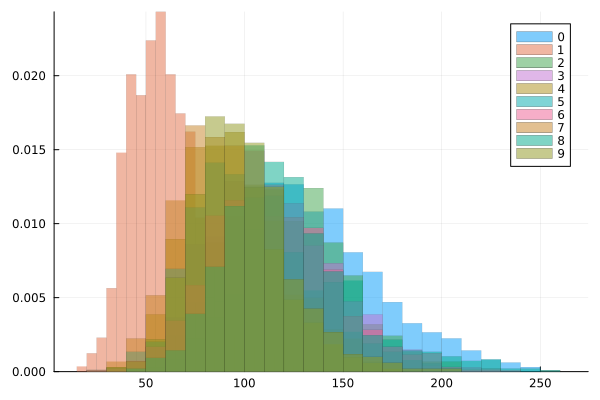

In [242]:
plot()
for j in 0:9
    plot!(diag(x_s[string(j)]' * x_s[string(j)]), st=:histogram, fillalpha=0.5, lw=0, label=j, normalized=true)
end
plot!()

In [ ]:
#Start

In [179]:
# Compute avg in v-h space -> project to x-y and then to u-w
λ = cpu(F.S);
x_s = Dict()
y_s = Dict()
v_s = Dict()
h_s = Dict()

for num_label in 0:9
    v = gpu(x_i[:,y_i .== num_label])
    h = Array{Float32}(sign.(rand(500, size(v,2)) |> dev .< σ.(β .* (dev(J.w)' * v .+ dev(J.b))))) |> dev

    x = cpu(F.U' * v)
    y = cpu(F.Vt * h);
    
    x_s[string(num_label)] = x
    y_s[string(num_label)] = y;
    
    v_s[string(num_label)] = cpu(v)
    h_s[string(num_label)] = cpu(h);

end

In [180]:
f(x,y,i, a0, b0, λ) = - (a0[i]*x + b0[i]*y + λ[i]*x*y )
λ = cpu(F.S)
a0 = cpu(F.U' * J.a)[1:size(λ,1)]
b0 = cpu(F.Vt * J.b);

In [181]:
num_label="1"
v_mean = reshape(mean(v_s[num_label], dims=2),:)
# v_mean = reshape(mean(hcat([v_s["$nl"] for nl in 0:9]...), dims=2),:)
x_mean = (cpu(F.U') * v_mean)[1:hparams.nh]

h_mean = reshape(mean(h_s[num_label], dims=2),:)
# h_mean = reshape(mean(hcat([h_s["$nl"] for nl in 0:9]...), dims=2),:)
y_mean = cpu(F.Vt) * h_mean

x_σ = diag(cpu(F.U') * mean([v_s[num_label][:,i] .* v_s[num_label][:,i]' for i in 1:size(v_s[num_label],2)]) * cpu(F.U))[1:hparams.nh]
y_σ = diag(cpu(F.Vt) * mean([h_s[num_label][:,i] .* h_s[num_label][:,i]' for i in 1:size(h_s[num_label],2)]) * cpu(F.V))
xy = diag(cpu(F.Vt) * mean([h_s[num_label][:,i] .* v_s[num_label][:,i]' for i in 1:size(h_s[num_label],2)]) * cpu(F.U))
xsp = - cpu(F.Vt * J.b) ./ λ
ysp = - cpu(F.U' * J.a)[1:hparams.nh] ./ λ

umean = 1/√2 .* (y_mean + x_mean - ysp - xsp)
u_σ =  1/2 .* (y_σ + x_σ + (ysp+xsp) .^2 + 2 .* xy - 2 .* (x_mean + y_mean) .* (xsp + ysp) )
σ_2u = u_σ .- umean .^ 2

wmean = 1/√2 .* (y_mean - x_mean - ysp + xsp)
w_σ =  1/2 .* (y_σ + x_σ + (ysp-xsp) .^2 - 2 .* xy - 2 .* (y_mean - x_mean ) .* (ysp - xsp) )
σ_2w = w_σ .- wmean .^ 2 ;

In [182]:
################
χ = sum(a0 .* b0 ./ λ .+ 1/2 .* (umean ./ (σ_2u .* (1 .+ λ .* σ_2u)) .+  wmean .^ 2 ./ (σ_2w .* (1 .- λ .* σ_2w))))
ent = sum(log.( σ_2u .* σ_2w))/2
@info χ, ent, s*log(2), s*log(2π), -s*log(2π) - ent + χ

[ Info: (253.3721971583252, -971.3028967214846, 346.5735902799726, 918.9385332046727, 305.73656067513707)


In [183]:
noise_u = randn(500, hparams.batch_size)
noise_w = randn(500, hparams.batch_size)
uNoise = umean .+ noise_u .* .√ σ_2u
wNoise = wmean .+ noise_w .* .√ σ_2w
qwert = [uwToxy(F,uNoise[:,i],wNoise[:,i]) for i in 1: hparams.batch_size];
xNoise, yNoise = hcat([qwert[i][1] for i in 1: hparams.batch_size]...), hcat([qwert[i][2] for i in 1: hparams.batch_size]...)

([-0.1891465323169323 0.39196765353405244 … 0.15125804385173386 -0.2493651725927726; 0.49596841255372026 0.21967793494499188 … -0.13845325804615938 0.20789767620126198; … ; -0.3626136641584195 0.18637009012444156 … -0.3122843747200013 -0.218088237344942; 0.2824385334390628 0.39550529445072546 … -0.5096321332776041 -0.5767715359869899], [-0.8188990534344176 -0.9291477822443925 … -0.5484196961407855 -0.5541988763463368; -0.14198049765927062 0.08234102053951604 … -0.32726500140631326 0.027870109533220513; … ; 0.28498513575655865 0.2821955426443058 … 1.035981625015725 0.05969723778942377; 0.553904186732756 0.1483862367284001 … -0.27896697514641405 0.25987202447637536])

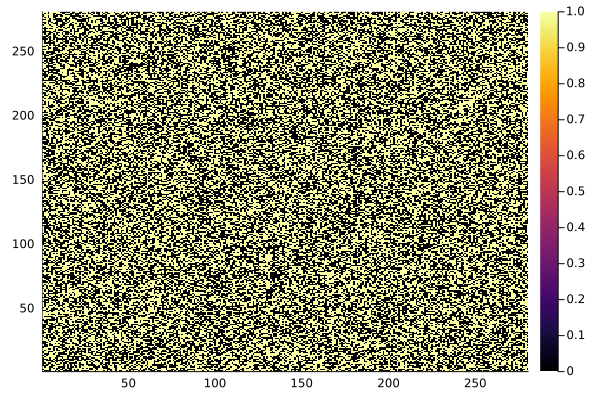

In [184]:
h = Array{Float32}(sign.(rand(hparams.nh, hparams.batch_size) |> dev .< σ.( F.V * dev(cat(Diagonal(F.S), (zeros(hparams.nv-hparams.nh,hparams.nh)),dims=1))' * dev(vcat(xNoise, zeros(784-500, hparams.batch_size))) .+ J.b))) |> dev
v = Array{Float32}(sign.(rand(hparams.nv, hparams.batch_size) |> dev .< σ.( F.U * dev(cat(Diagonal(F.S), (zeros(hparams.nv-hparams.nh,hparams.nh)),dims=1)) * dev(yNoise) .+ J.a))) |> dev;
lnum=10
heatmap(cat([cat([reshape(cpu(v)[:,i+j*lnum],28,28) for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1))

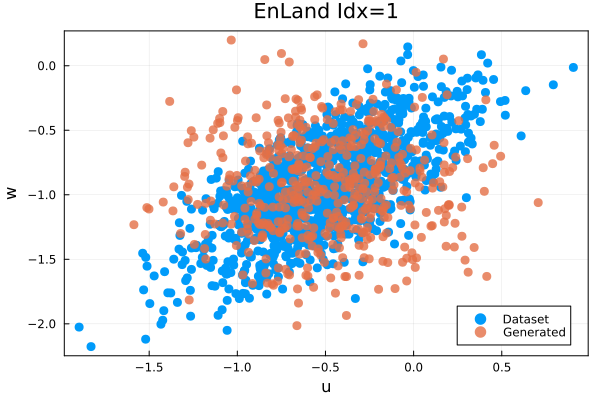

In [185]:


s=500
# num_label = "8"
s2 = size(x_s[num_label],2)
Rot = Tridiagonal([ isodd(i) ? 1 : 0 for i in 1:2*s-1] , [1 for i in 1:2*s] , [ isodd(i) ? -1 : 0 for i in 1:2*s-1])

xyMinusSp = vcat(x_s[num_label][1:500,:] .+ b0 ./ λ, y_s[num_label][1:500,:] .+ a0 ./ λ)[Array(reshape(hcat(1:500, 501:1000)',:)),:]
uw0 = inv(1/√2 * Rot) * xyMinusSp
uData, wData = hcat([reshape(uw0[:,i]', 2,:)'[:,1] for i in 1:s2]...), hcat([reshape(uw0[:,i]', 2,:)'[:,2] for i in 1:s2]...);

idx = 1

plot(uData[idx,:], wData[idx,:], st=:scatter, markerstrokewidth=0.0, label="Dataset", ms=5)
plot!(uNoise[idx,:], wNoise[idx,:], st=:scatter, markerstrokewidth=0.0, ms=5, opacity=0.8, label="Generated")
plot!(frame=:box, xlabel="u", ylabel="w", title="EnLand Idx=$idx")

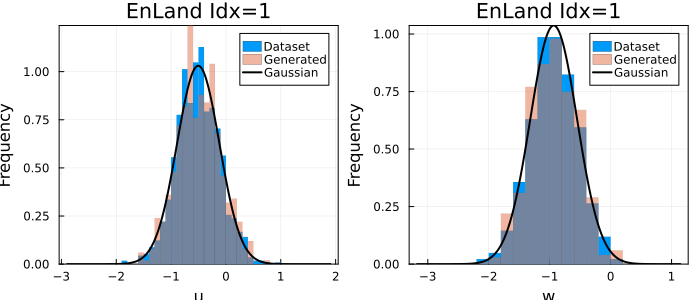

In [186]:
# idx = 400

ustar = reshape(mean(uData, dims=2),:)
wstar = reshape(mean(wData, dims=2),:)
σ2u = reshape(var(uData, dims=2),:)
σ2w = reshape(var(wData, dims=2),:)

μu = ustar[idx]
σ2uu = σ2u[idx]

μw = wstar[idx]
σ2ww = σ2w[idx]

p1 = plot(uData[idx,:], st=:histogram, bins=40, normalize=true, lw=0, label="Dataset") # yaxis = (:log10, (0.00001,Inf)),
p1 = plot!(uNoise[idx,:], st=:histogram, bins=40,  normalize=true, lw=0, opacity=0.5, label="Generated")
p1 = plot!(minimum(uData[idx,:])-1:0.01:1+maximum(uData[idx,:]), x->1/√(2π*σ2uu) * exp(-(x-μu)^2/(2*σ2uu)),lw=2, c=:black, frame=:box, xlabel="u", ylabel="Frequency", label="Gaussian", title="EnLand Idx=$idx")
p2 = plot(wData[idx,:], st=:histogram, bins=20,  normalize=true, lw=0, label="Dataset")
p2 = plot!(wNoise[idx,:], st=:histogram, bins=20,  normalize=true, lw=0, opacity=0.5, label="Generated")
p2 = plot!(minimum(wData[idx,:])-1:0.01:1+maximum(wData[idx,:]), x->1/√(2π*σ2ww) * exp(-(x-μw)^2/(2*σ2ww)), lw=2, c=:black, frame=:box, xlabel="w", ylabel="Frequency", label="Gaussian", title="EnLand Idx=$idx")
plot(p1,p2, size=(700,300))

In [126]:
# plot(σ_2u, σ2u)
# # plot!(σ2u)
# plot((σ_2u .- σ2u))
# # plot((σ_2u .- σ2u) ./ σ2u)

In [216]:
# plot(σ_2w)
# plot!(σ2w)
# plot(σ2w .- σ_2w)

In [218]:
num=1000
xh = sign.(rand(hparams.nh, num) .< 0.5) |> dev
rbm.v = Array{Float32}(sign.(rand(hparams.nv, num) |> dev .< σ.(β .* (J.w * xh .+ J.a)))) |> dev
for i in 1:100
    rbm.h = Array{Float32}(sign.(rand(hparams.nh, num) |> dev .< σ.(β .* (J.w' * rbm.v .+ J.b)))) |> dev
    rbm.v = Array{Float32}(sign.(rand(hparams.nv, num) |> dev .< σ.(β .* (J.w * rbm.h .+ J.a)))) |> dev 
end

In [220]:
function data_val_samples(F)
    # x_i, y_i = loadData(; hparams, dsName="MNIST01", numbers=collect(0:9), testset=true);
    
    # Compute avg in v-h space -> project to x-y and then to u-w
    λ = cpu(F.S);
    x_s = Dict()
    y_s = Dict()
    v_s = Dict()
    h_s = Dict()

    for num_label in 0:9
        v = gpu(x_i[:,y_i .== num_label])
        h = Array{Float32}(sign.(rand(500, size(v,2)) |> dev .< σ.(β .* (dev(J.w)' * v .+ dev(J.b))))) |> dev

        x = cpu(F.U' * v)
        y = cpu(F.Vt * h);

        x_s[string(num_label)] = x
        y_s[string(num_label)] = y;

        v_s[string(num_label)] = cpu(v)
        h_s[string(num_label)] = cpu(h);
    end
    return hcat([v_s["$nl"] for nl in 0:9]...), hcat([h_s["$nl"] for nl in 0:9]...)
end
    

data_val_samples (generic function with 1 method)

In [203]:
function compute_stats(v, h, J)
    J.w = cpu(J.w)
    J.b = cpu(J.b)
    J.a = cpu(J.a)
    v = cpu(v)
    h = cpu(h)
    F = LinearAlgebra.svd(J.w, full=true);
    λ = cpu(F.S)
    a0 = cpu(F.U' * J.a)[1:size(λ,1)]
    b0 = cpu(F.Vt * J.b);
    
    l = minimum([size(v,1), size(h,1)])
    v_mean = reshape(mean(v, dims=2),:)
    x_mean = (F.U' * v_mean)[1:l]

    h_mean = reshape(mean(h, dims=2),:)
    y_mean = (F.Vt * h_mean)

    x_σ = diag(F.U' * mean([v[:,i] .* v[:,i]' for i in 1:size(v,2)]) * F.U)[1:l]
    y_σ = diag(F.Vt * mean([h[:,i] .* h[:,i]' for i in 1:size(h,2)]) * F.V)
    xy = diag(F.Vt * mean([h[:,i] .* v[:,i]' for i in 1:size(h,2)]) * F.U)

    umean = 1/√2 .* (cpu(y_mean + x_mean) - ysp - xsp)
    u_σ =  1/2 .* (cpu(y_σ + x_σ) + (ysp+xsp) .^2 + 2 .* cpu(xy) - 2 .* cpu(x_mean + y_mean) .* (xsp + ysp) )
    σ_2u = u_σ .- umean .^ 2

    wmean = 1/√2 .* (cpu(y_mean - x_mean) - ysp + xsp)
    w_σ =  1/2 .* (cpu(y_σ + x_σ) + (ysp-xsp) .^2 - 2 .* cpu(xy) - 2 .* cpu(y_mean - x_mean ) .* (ysp - xsp) )
    σ_2w = w_σ .- wmean .^ 2 ;
    
    return umean, wmean, σ_2u, σ_2w, a0, b0, λ
end

function compute_therm(umean, wmean, σ_2u, σ_2w, a0, b0, λ)
    U = sum(a0 .* b0 ./ λ .+ 1/2 .* (umean ./ (σ_2u .* (1 .+ λ .* σ_2u)) .+  wmean .^ 2 ./ (σ_2w .* (1 .- λ .* σ_2w))))
    Σ = sum(log.( σ_2u .* σ_2w))/2
    F = U - Σ - size(λ,1)*log(2π)
    return U, Σ, F, exp(-F)
end

compute_therm (generic function with 1 method)

In [219]:
umean, wmean, σ_2u, σ_2w, a0, b0, λ = compute_stats(rbm.v, rbm.h, J)
@info compute_therm(umean, wmean, σ_2u, σ_2w, a0, b0, λ)

In [ ]:
umean, wmean, σ_2u, σ_2w, a0, b0, λ = compute_stats(rbm.v, rbm.h, J)
@info compute_therm(umean, wmean, σ_2u, σ_2w, a0, b0, λ)

In [204]:
vrbm_mean = reshape(mean(rbm.v, dims=2),:)
xrbm_mean = (F.U' * vrbm_mean)[1:hparams.nh]

hrbm_mean = reshape(mean(rbm.h, dims=2),:)
yrbm_mean = (F.Vt * hrbm_mean)

xrbm_σ = diag(F.U' * mean([rbm.v[:,i] .* rbm.v[:,i]' for i in 1:size(rbm.v,2)]) * F.U)[1:hparams.nh]
yrbm_σ = diag(F.Vt * mean([rbm.h[:,i] .* rbm.h[:,i]' for i in 1:size(rbm.h,2)]) * F.V)
xyrbm = diag(F.Vt * mean([rbm.h[:,i] .* rbm.v[:,i]' for i in 1:size(rbm.h,2)]) * F.U)

urbmmean = 1/√2 .* (cpu(yrbm_mean + xrbm_mean) - ysp - xsp)
urbm_σ =  1/2 .* (cpu(yrbm_σ + xrbm_σ) + (ysp+xsp) .^2 + 2 .* cpu(xyrbm) - 2 .* cpu(xrbm_mean + yrbm_mean) .* (xsp + ysp) )
σrbm_2u = urbm_σ .- urbmmean .^ 2

wrbmmean = 1/√2 .* (cpu(yrbm_mean - xrbm_mean) - ysp + xsp)
wrbm_σ =  1/2 .* (cpu(yrbm_σ + xrbm_σ) + (ysp-xsp) .^2 - 2 .* cpu(xyrbm) - 2 .* cpu(yrbm_mean - xrbm_mean ) .* (ysp - xsp) )
σrbm_2w = wrbm_σ .- wrbmmean .^ 2 ;


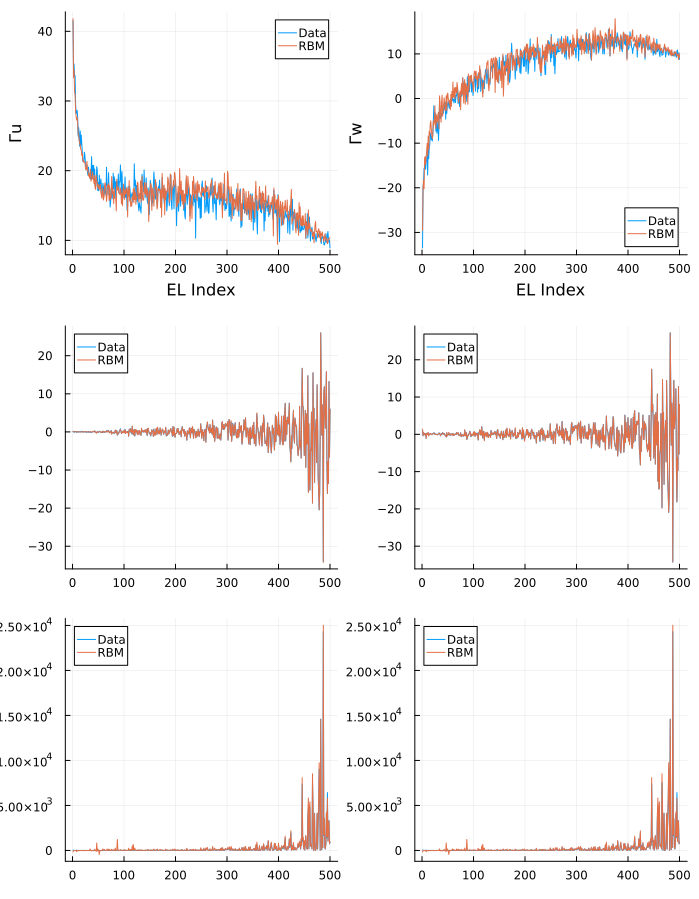

In [173]:
p1 = plot(λ .+ 1 ./ σ_2u, label="Data", xlabel="EL Index", ylabel="Γu")
p1 = plot!(λ .+ 1 ./ σrbm_2u, label="RBM")

p2 = plot(-λ .+ 1 ./ σ_2w, label="Data", xlabel="EL Index", ylabel="Γw")
p2 = plot!(-λ .+ 1 ./ σrbm_2w, label="RBM")

p3 = plot(umean ./ (1 .+ λ .* σ_2u), label="Data")
p3 = plot!(urbmmean ./ (1 .+ λ .* σrbm_2u), label="RBM")

p4 = plot(wmean ./ (1 .+ λ .* σ_2w), label="Data")
p4 = plot!(wrbmmean ./ (1 .+ λ .* σrbm_2w), label="RBM")

p5 = plot(umean .^ 2 ./ (σ_2u .* (1 .+ λ .* σ_2u)) + wmean .^ 2 ./ (σ_2w .* (1 .+ λ .* σ_2w)), label="Data")
p6 = plot!(urbmmean .^ 2 ./ (σrbm_2u .* (1 .+ λ .* σrbm_2u)) + wrbmmean .^ 2 ./ (σrbm_2w .* (1 .- λ .* σrbm_2w)), label="RBM")

plot(p1,p2,p3,p4,p5,p6, layout=(3,2), size=(700,900))

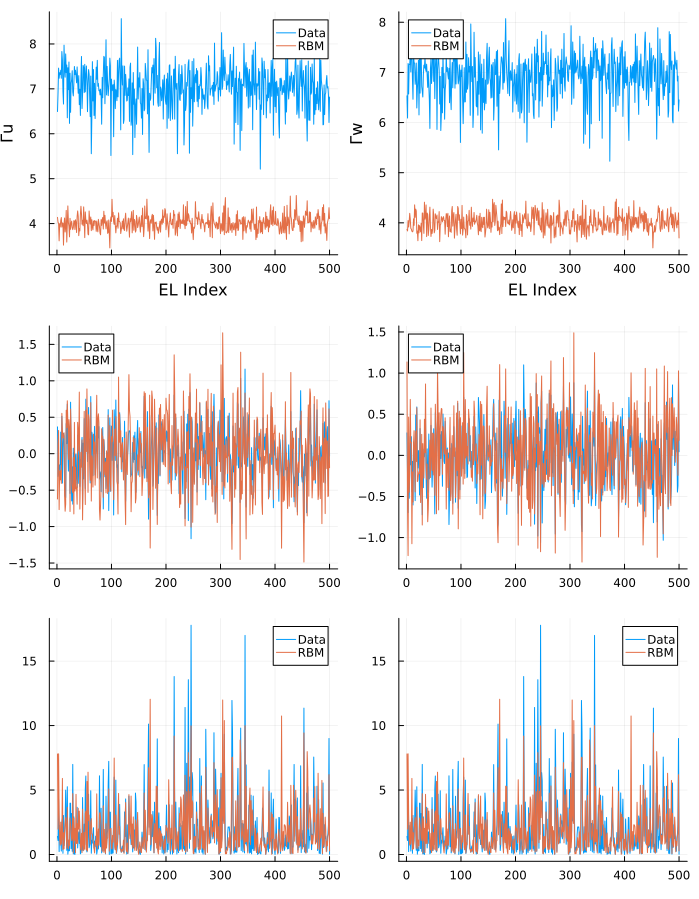

In [125]:
p1 = plot(λ .+ 1 ./ σ_2u, label="Data", xlabel="EL Index", ylabel="Γu")
p1 = plot!(λ .+ 1 ./ σrbm_2u, label="RBM")

p2 = plot(-λ .+ 1 ./ σ_2w, label="Data", xlabel="EL Index", ylabel="Γw")
p2 = plot!(-λ .+ 1 ./ σrbm_2w, label="RBM")

p3 = plot(umean ./ (1 .+ λ .* σ_2u), label="Data")
p3 = plot!(urbmmean ./ (1 .+ λ .* σrbm_2u), label="RBM")

p4 = plot(wmean ./ (1 .+ λ .* σ_2w), label="Data")
p4 = plot!(wrbmmean ./ (1 .+ λ .* σrbm_2w), label="RBM")

p5 = plot(umean .^ 2 ./ (σ_2u .* (1 .+ λ .* σ_2u)) + wmean .^ 2 ./ (σ_2w .* (1 .+ λ .* σ_2w)), label="Data")
p6 = plot!(urbmmean .^ 2 ./ (σrbm_2u .* (1 .+ λ .* σrbm_2u)) + wrbmmean .^ 2 ./ (σrbm_2w .* (1 .- λ .* σrbm_2w)), label="RBM")

plot(p1,p2,p3,p4,p5,p6, layout=(3,2), size=(700,900))

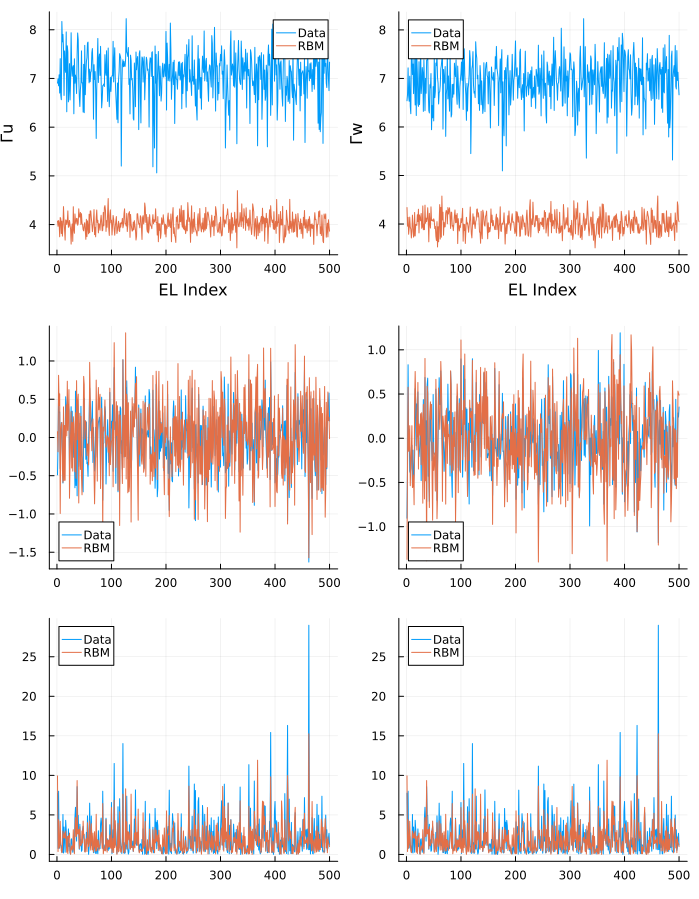

In [189]:
p1 = plot(λ .+ 1 ./ σ_2u, label="Data", xlabel="EL Index", ylabel="Γu")
p1 = plot!(λ .+ 1 ./ σrbm_2u, label="RBM")

p2 = plot(-λ .+ 1 ./ σ_2w, label="Data", xlabel="EL Index", ylabel="Γw")
p2 = plot!(-λ .+ 1 ./ σrbm_2w, label="RBM")

p3 = plot(umean ./ (1 .+ λ .* σ_2u), label="Data")
p3 = plot!(urbmmean ./ (1 .+ λ .* σrbm_2u), label="RBM")

p4 = plot(wmean ./ (1 .+ λ .* σ_2w), label="Data")
p4 = plot!(wrbmmean ./ (1 .+ λ .* σrbm_2w), label="RBM")

p5 = plot(umean .^ 2 ./ (σ_2u .* (1 .+ λ .* σ_2u)) + wmean .^ 2 ./ (σ_2w .* (1 .- λ .* σ_2w)), label="Data")
p6 = plot!(urbmmean .^ 2 ./ (σrbm_2u .* (1 .+ λ .* σrbm_2u)) + wrbmmean .^ 2 ./ (σrbm_2w .* (1 .- λ .* σrbm_2w)), label="RBM")

plot(p1,p2,p3,p4,p5,p6, layout=(3,2), size=(700,900))

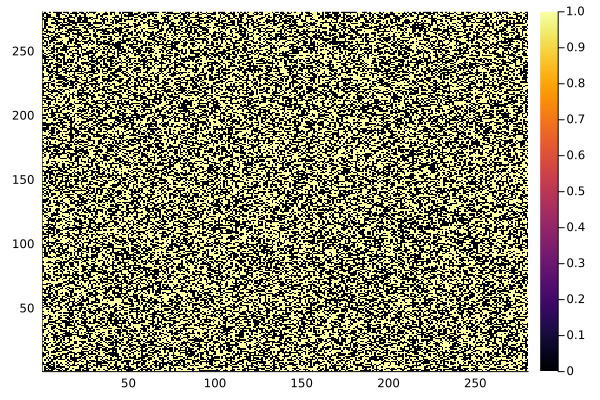

In [206]:
heatmap(cat([cat([reshape(cpu(rbm.v)[:,i+j*lnum],28,28) for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1))

In [191]:
################
χrbm = sum(a0 .* b0 ./ λ .+ 1/2 .* (urbmmean ./ (σrbm_2u .* (1 .+ λ .* σrbm_2u)) .+  wrbmmean .^ 2 ./ (σrbm_2w .* (1 .- λ .* σrbm_2w))))
entrbm = sum(log.( σrbm_2u .* σrbm_2w))/2
@info χ, ent, s*log(2), s*log(2π), -s*log(2π) - ent + χ
@info χrbm, entrbm, s*log(2), s*log(2π), -s*log(2π) - entrbm + χrbm

[ Info: (253.3721971583252, -971.3028967214846, 346.5735902799726, 918.9385332046727, 305.73656067513707)
[ Info: (247.14178850310455, -694.8764333108523, 346.5735902799726, 918.9385332046727, 23.079688609284204)
